# Steam Game Analysis using Kaggle dataset

reference from ...

https://www.kaggle.com/simonprevoteaux/steam-game-analysis

https://www.kaggle.com/philschmidt/steam-users-and-games-eda

https://www.kaggle.com/phaethonprime/quick-look-most-played-games

---

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import KMeans
import networkx as nx
from itertools import combinations

In [27]:
%matplotlib inline

In [13]:
### call the df

df = pd.read_csv("steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Others'])
df.head()

,UserID,Game,Action,Hours,Others
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [14]:
### basic description for play times 

df.loc[df['Action'] == 'play'].describe()

,UserID,Hours,Others
count,7.048900e+04,70489.000000,70489.0
mean,1.058812e+08,48.878063,0.0
std,7.150365e+07,229.335236,0.0
min,5.250000e+03,0.100000,0.0
25%,4.934256e+07,1.000000,0.0
50%,9.169067e+07,4.500000,0.0
75%,1.556738e+08,19.100000,0.0
max,3.099031e+08,11754.000000,0.0


- 총 70489시간, 평균 48.8시간, 최대 11754시간, 최소 0.1시간, 제2사분위 4.5시간


In [15]:
### groupby DF

values = df.groupby(['UserID', 'Action']).size()
values.head()

UserID  Action  
5250    play         6
        purchase    21
76767   play        20
        purchase    36
86540   play        15
dtype: int64

In [16]:
print("Number of games : {0}".format(len(df.Game.unique())))
print("Number of users : {0}".format(len(df.UserID.unique())))
print("Number of total purchases : {0}".format(len(df.loc[df['Action'] == 'purchase'])))
print("Number of total plays infos : {0}".format(len(df.loc[df['Action'] == 'play'])))

Number of games : 5155
Number of users : 12393
Number of total purchases : 129511
Number of total plays infos : 70489


In [17]:
# See the top 15 that games take up the most time
pdf = df[df.Action=='play']
pdf.shape
pdf[pdf.Hours > 1000].Game.value_counts()[:15]

Dota 2                                         307
Counter-Strike Global Offensive                 66
Counter-Strike                                  45
Team Fortress 2                                 40
Counter-Strike Source                           21
Sid Meier's Civilization V                      15
Football Manager 2012                            8
Football Manager 2014                            7
Call of Duty Modern Warfare 2 - Multiplayer      6
Football Manager 2013                            6
Garry's Mod                                      6
Mount & Blade Warband                            5
Football Manager 2015                            5
The Elder Scrolls V Skyrim                       5
Call of Duty Black Ops - Multiplayer             4
Name: Game, dtype: int64

In [18]:
pdf[pdf.Hours == pdf.Hours.max()].UserID

123726    73017395
Name: UserID, dtype: int64

In [19]:
actions = df.groupby('Action')['Action'].agg('count')
actions = pd.DataFrame({'action': actions.index, 'n': actions.values})
sns.barplot(x = 'action', y = 'n', data = actions)

In [20]:
print("Number of games : {0}".format(len(df.Game.unique())))
print("Number of users : {0}".format(len(df.UserID.unique())))
print("Number of total purchases : {0}".format(len(df.loc[df['Action'] == 'purchase'])))
print("Number of total plays infos : {0}".format(len(df.loc[df['Action'] == 'play'])))

Number of games : 5155
Number of users : 12393
Number of total purchases : 129511
Number of total plays infos : 70489


In [21]:
user_counts = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)
user_counts = pd.DataFrame({'user': user_counts.index, 'hours': user_counts.values})[0:20]
user_counts['hours'].plot.bar()
plt.title('Top 20 users hours played')
plt.ylabel('Hours')

In [22]:
# 20:80 pareto principle

user_counts = df.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
user_df = pd.DataFrame({'user': user_counts.index, 'n': user_counts.values})
user_df.head()

,n,user
0,1573,62990992
1,949,33865373
2,906,11403772
3,901,30246419
4,855,47457723


In [26]:
n_events = np.sum(user_df['n'])
csum = np.cumsum(100.0*user_df['n']/n_events)

# 80% of data
threshold = 80.0

threshold_idx = np.argmin(np.abs(csum-threshold))
plt.plot(csum)
plt.axvline(threshold_idx, color='r')
plt.title('cumulative sum of user event counts')
print('We have found that {} users out of {} ({}%) in total explain {}% of the events in the data.'.format(threshold_idx, user_df.shape[0], 100.0*threshold_idx/user_df.shape[0], threshold))

We have found that 2118 users out of 12393 (17.090292907286372%) in total explain 80.0% of the events in the data.


In [29]:
game_counts = df.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
game_df = pd.DataFrame({'game': game_counts.index, 'n': game_counts.values})
game_df.head()

,game,n
0,Dota 2,9682
1,Team Fortress 2,4646
2,Counter-Strike Global Offensive,2789
3,Unturned,2632
4,Left 4 Dead 2,1752


We have found that 832 games out of 5155 (6.713467279916082%) in total explain 80.0% of the events in the data.


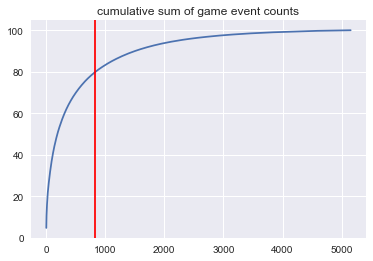

In [43]:
n_events = np.sum(game_df['n'])
csum = np.cumsum((100.0*game_df['n']/n_events))

# 80% of data
threshold = 80.0

threshold_idx = np.argmin(np.abs(csum-threshold))
plt.plot(csum)
plt.axvline(threshold_idx, color='r')
plt.title('cumulative sum of game event counts')
print('We have found that {} games out of {} ({}%) in total explain {}% of the events in the data.'.format(threshold_idx, game_df.shape[0], 100.0*threshold_idx/user_df.shape[0], threshold))

In [120]:
top_users = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False).index[0:50]
top_games = df.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False).index[0:20]

In [121]:
dff = df[df['UserID'].isin(top_users)]
dff = dff[dff['Game'].isin(top_games)]
pivoted = pd.pivot_table(dff, values='Hours', index=['UserID'], columns=['Game'], aggfunc=np.sum).fillna(0)
s = pivoted.max().max()
pivoted = pivoted / s
pivoted.shape

(50, 20)

we can see that there is a cluster of users who play the whole football manager series

also there is a smaller cluster for CS global offensive, Counter-Strike and Counter-Strike source

another cluster of users who play call of duty game series

/Users/Yeoni/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


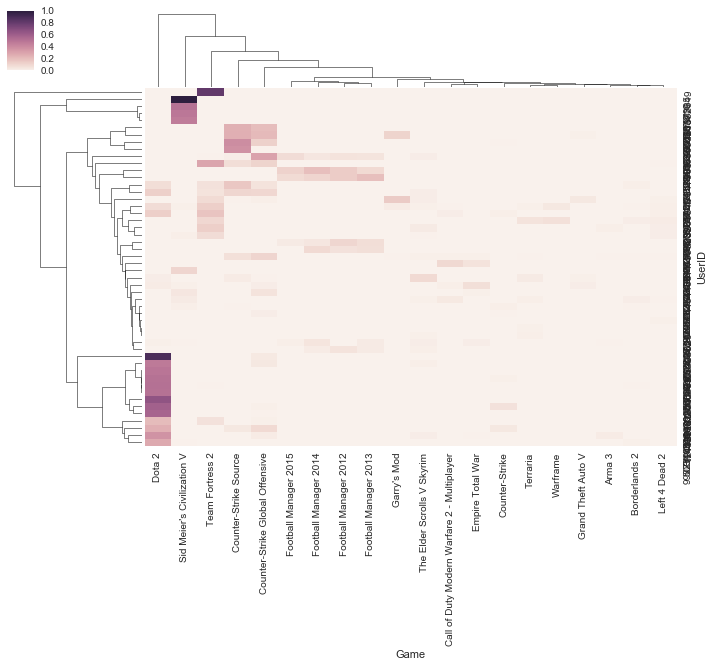

In [124]:
sns.clustermap(pivoted, figsize=(12,8))

## game analysis

In [98]:
# counts out each games

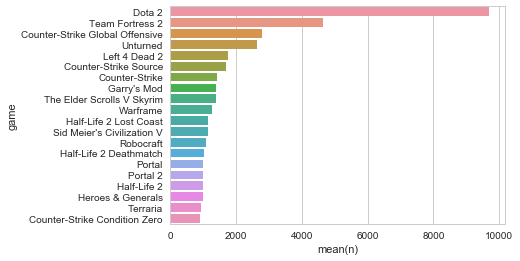

In [96]:
game_counts = df.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
game_counts = pd.DataFrame({'game': game_counts.index, 'n': game_counts.values})[0:20]
sns.barplot(y = 'game', x = 'n', data = game_counts)

In [99]:
# sum of playing hours

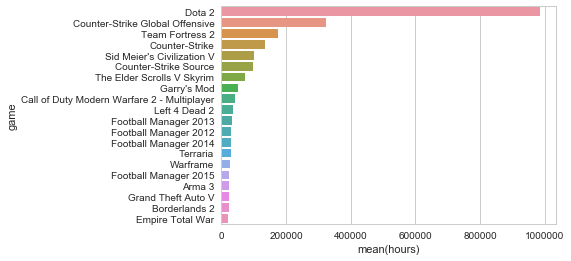

In [97]:
game_counts = df.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
game_counts = pd.DataFrame({'game': game_counts.index, 'hours': game_counts.values})[0:20]
sns.barplot(y = 'game', x = 'hours', data = game_counts)

In [74]:
## calculating purchase time

nb_games = 10
df_purchase = df.loc[df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

In [75]:
## calculating play time

df_play = df.loc[df['Action'] == 'play']
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

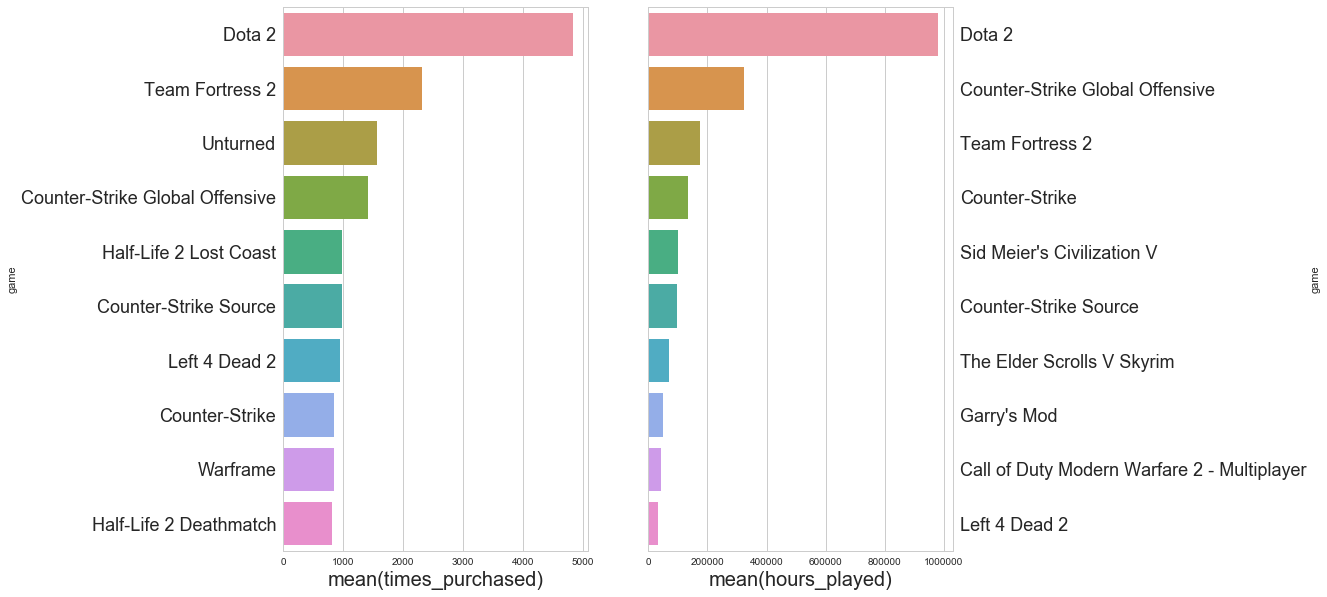

In [76]:
## Draw bar chart(purchase / play times)

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

In [34]:
## Sort active users by playing hours.

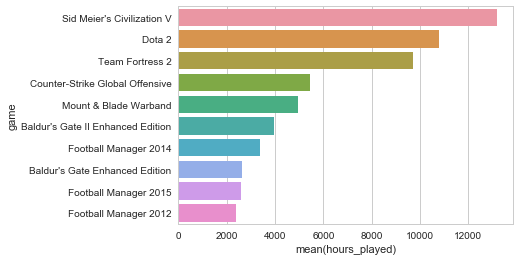

In [77]:
top = 10
user_counts = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = df['UserID'].isin(user_counts.index)
df_infos_user = df.loc[mask].loc[df['Action'] == 'play']
hours_played = df_infos_user.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)

In [41]:
## sort famous game but played less VS less known but played more and caused hardcore gaming

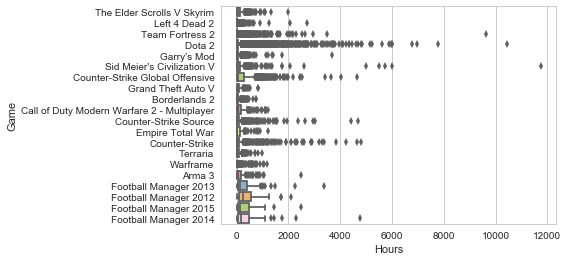

In [78]:
nb_top_games = 20
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
top_played_games = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_top_games]

mask = df['Game'].isin(top_played_games['game'])

df_infos_user = df.loc[mask].loc[df['Action'] == 'play'][['Hours', 'Game']]


sns.set_style("whitegrid")
sns.boxplot(x="Hours", y="Game", data=df_infos_user, palette="Set3")

In [43]:
## User Classification

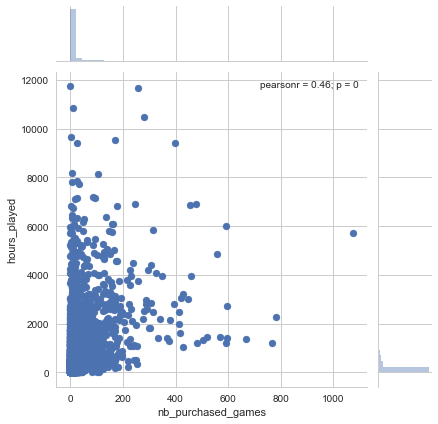

In [86]:
df_purchased_games = df.loc[df['Action'] == 'purchase']
df_played_games = df.loc[df['Action'] == 'play']

#here we compute the number of games a user has bought
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

#merge to have one entry per user with number of hours played and number of purchased games
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data)# , kind="reg")

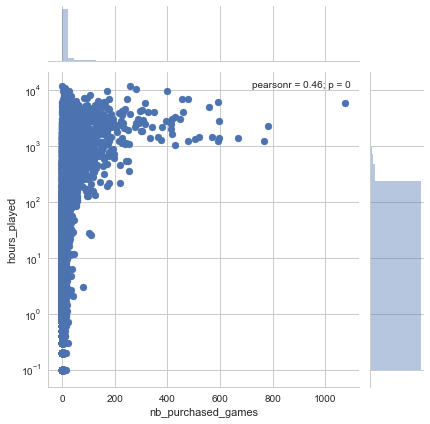

In [87]:
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data = data) #, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

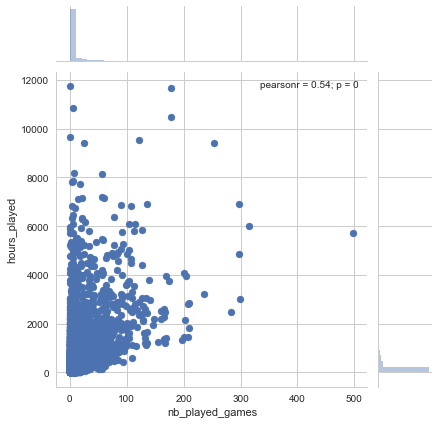

In [88]:
#here we compute the number of games a user has played
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})


#merge to have one entry per user with number of hours played and number of played games
data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')

sns.jointplot(x="nb_played_games", y="hours_played", data=data )# , kind="reg")

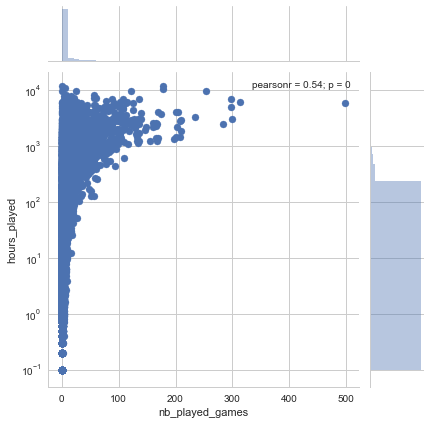

In [89]:
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

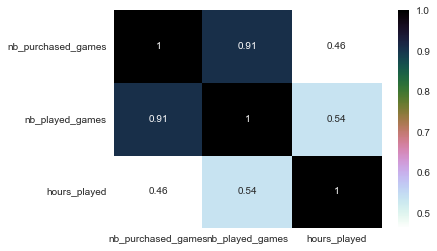

In [90]:
temp = pd.merge(user_df_purchased_games, data, on='UserID')
temp = temp.copy()
del temp['UserID'] #don't need this for k mean
sns.heatmap(temp.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlatio

In [50]:
## K-means

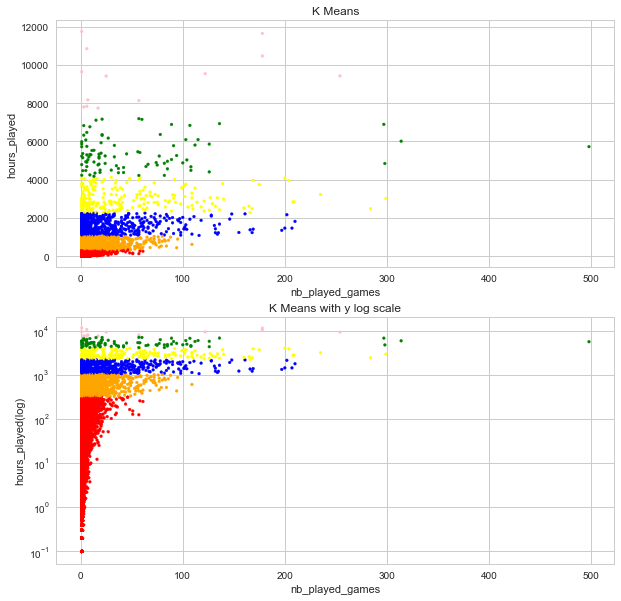

In [92]:
temp = data.copy()
del temp['UserID'] #don't need this for k mean

N_CLUSTERS = 6
train_data = temp.as_matrix()
# Using sklearn
km = KMeans(n_clusters=N_CLUSTERS)
km.fit(train_data)
# Get cluster assignment labels
labels = km.labels_ # 0 to n_clusters-1
# Format results as a DataFrame

LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'yellow',
                   4 : 'orange',
                   5 : 'pink'
                  }

label_color = [LABEL_COLOR_MAP[l] for l in labels]


fig, ax =plt.subplots(2,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('K Means')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('K Means with y log scale')
ax[1].set_yscale('log')

In [61]:
## Gaussian Mixture

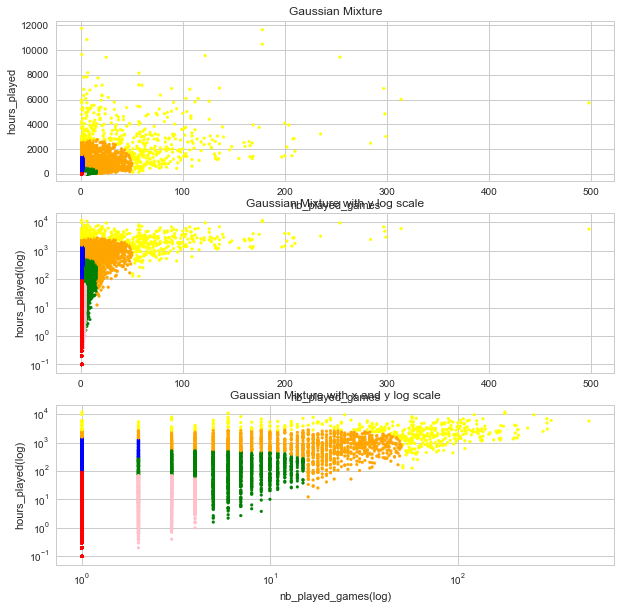

In [93]:
from sklearn.mixture import GaussianMixture
cov_types = ['spherical', 'diag', 'tied', 'full']

gm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gm.fit(train_data)
y_train_pred = gm.predict(train_data)
label_color = [LABEL_COLOR_MAP[l] for l in y_train_pred]

fig, ax =plt.subplots(3,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('Gaussian Mixture')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('Gaussian Mixture with y log scale')
ax[1].set_yscale('log')

ax[2].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[2].set_xlabel('nb_played_games(log)')
ax[2].set_ylabel('hours_played(log)')
ax[2].set_title('Gaussian Mixture with x and y log scale')
ax[2].set_yscale('log')
ax[2].set_xscale('log')

In [129]:
# play game together

In [134]:
G = nx.Graph()
for user_id in pdf.UserID.unique():
    games = pdf[pdf.UserID==user_id].Game.tolist()
    for g1, g2 in combinations(sorted(games), 2):
        if G.has_edge(g1, g2 ):
            G[g1][g2]['weight'] += 1
        else:
            G.add_edge(g1, g2 , weight=1)

In [135]:
len(G.node), pdf.Game.unique().shape[0], df.Game.unique().shape[0]

(3577, 3600, 5155)

In [136]:
cent = nx.centrality.eigenvector_centrality_numpy(G, weight='weight')

In [137]:
for c in sorted(cent, key=cent.__getitem__, reverse=True)[:20]:
    print(c)

Team Fortress 2
Counter-Strike Global Offensive
Dota 2
Left 4 Dead 2
The Elder Scrolls V Skyrim
Garry's Mod
Unturned
Portal 2
Terraria
Borderlands 2
Counter-Strike Source
PAYDAY 2
Sid Meier's Civilization V
Portal
Half-Life 2
Warframe
Fallout New Vegas
Alien Swarm
Saints Row The Third
Grand Theft Auto IV


In [138]:
pdf.Game.value_counts(normalize=True)[:15]

Dota 2                             0.068677
Team Fortress 2                    0.032955
Counter-Strike Global Offensive    0.019535
Unturned                           0.015165
Left 4 Dead 2                      0.011363
Counter-Strike Source              0.010143
The Elder Scrolls V Skyrim         0.009604
Garry's Mod                        0.009448
Counter-Strike                     0.008058
Sid Meier's Civilization V         0.007859
Terraria                           0.006526
Portal 2                           0.006427
Warframe                           0.006015
Portal                             0.005916
Robocraft                          0.005774
Name: Game, dtype: float64